In [37]:
branch_depths = [50, 100, 150, 200, 250, 300]
# branch_depths = [150]
trunk_depths = [10, 20, 30, 40, 50, 60]
don_depths = [2, 3, 4, 5]
don_widths = [4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [38]:
import os
import json

operators = ['Inverse', 'Homogeneous', 'Nonlinear', 'RDiffusion', 'Advection', 'Darcy']
seeds = [0, 1, 2, 3, 4]
models = ['DeepONet_nobias', 'DeepONet', 'FNN']

for operator in operators:
    for seed in seeds:
        for model in models:
            log_path = f'dairy/training_{operator}_{model}_1_{seed}.log'
            json_path = f'logs/{operator}/training_{operator}_{model}_1_{seed}.json'
            min_train_loss = float('inf')
            test_loss_at_min_train = None
            if not os.path.exists(log_path):
                print(f'File not found: {log_path}')
            else:
                with open(log_path, 'r') as f:
                    for line in f:
                        if line.startswith('Epoch'):
                            parts = line.strip().split(':')
                            if len(parts) == 2:
                                losses = parts[1].split(',')
                                if len(losses) == 2:
                                    train_loss = float(losses[0].strip())
                                    test_loss = float(losses[1].strip())
                                    if train_loss < min_train_loss:
                                        min_train_loss = train_loss
                                        test_loss_at_min_train = test_loss
                if test_loss_at_min_train is not None:
                    os.makedirs(f'logs/{operator}', exist_ok=True)
                    with open(json_path, 'w') as f:
                        json.dump({'MSE': test_loss_at_min_train}, f, indent=2)
                else:
                    print(f'No valid train/test loss found in {log_path}')

In [39]:
import json
import numpy as np
seeds = [0, 1, 2, 3, 4]
model_types = ['HEAQNN', 'TF-HEAQNN', 'QuanONet', 'TF-QuanONet', 'DeepONet', 'FNN', 'DeepONet_nobias']
# operators = ['RDiffusion','Advection', 'Darcy']
operators = ['Inverse', 'Homogeneous', 'Nonlinear' , 'RDiffusion','Advection', 'Darcy']
mean = {}
std = {}
for operator in operators:
    mean[operator] = {}
    std[operator] = {}
    for model_type in model_types:
        mean[operator][model_type] = {}
        std[operator][model_type] = {}
        if model_type in ['HEAQNN', 'TF-HEAQNN', 'QuanONet', 'TF-QuanONet']:
            coeffs = [0.001, 0.01, 0.1]
        else:
            coeffs = [1]
        for coeff in coeffs:
            mean[operator][model_type][coeff] = {}
            std[operator][model_type][coeff] = {}
            temp = []
            for seed in seeds:
                file_path = f'logs/{operator}/training_{operator}_{model_type}_{coeff}_{seed}.json'
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                        temp.append(data['MSE'])
                        # print(f"Loaded MSE from {file_path}: {data['MSE']}")
                except FileNotFoundError:
                    temp.append({"error": "File not found"})
                except json.JSONDecodeError:
                    temp.append({"error": "JSON decode error"})
            mse_values = [v for v in temp if isinstance(v, (int, float))]
            if mse_values:
                mean[operator][model_type][coeff] = np.mean(mse_values)
                std[operator][model_type][coeff] = np.std(mse_values)
                print(f"for {operator}, {model_type}, {coeff}: {mean[operator][model_type][coeff]:.6f} \pm {std[operator][model_type][coeff]:.6f}")
            else:
                mean[operator][model_type][coeff] = None
                std[operator][model_type][coeff] = None


for Inverse, DeepONet, 1: 0.000516 \pm 0.000186
for Inverse, FNN, 1: 0.000761 \pm 0.000347
for Inverse, DeepONet_nobias, 1: 0.000525 \pm 0.000185
for Homogeneous, DeepONet, 1: 0.000520 \pm 0.000179
for Homogeneous, FNN, 1: 0.000994 \pm 0.000739
for Homogeneous, DeepONet_nobias, 1: 0.000512 \pm 0.000179
for Nonlinear, DeepONet, 1: 0.028176 \pm 0.001185
for Nonlinear, FNN, 1: 0.024020 \pm 0.007168
for Nonlinear, DeepONet_nobias, 1: 0.027646 \pm 0.000466
for RDiffusion, DeepONet, 1: 0.001227 \pm 0.000484
for RDiffusion, FNN, 1: 0.001884 \pm 0.000152
for RDiffusion, DeepONet_nobias, 1: 0.001621 \pm 0.000104
for Advection, HEAQNN, 0.001: 0.645773 \pm 0.003355
for Advection, HEAQNN, 0.01: 0.543537 \pm 0.001491
for Advection, HEAQNN, 0.1: 0.546454 \pm 0.001269
for Advection, TF-HEAQNN, 0.001: 0.490384 \pm 0.052142
for Advection, TF-HEAQNN, 0.01: 0.267750 \pm 0.121106
for Advection, TF-HEAQNN, 0.1: 0.098211 \pm 0.002321
for Advection, QuanONet, 0.001: 0.746731 \pm 0.003136
for Advection, QuanO

In [40]:
for model_type in ['HEAQNN', 'TF-HEAQNN', 'QuanONet', 'TF-QuanONet', 'DeepONet',  'DeepONet_nobias', 'FNN']:
    if model_type in ['HEAQNN', 'TF-HEAQNN', 'QuanONet', 'TF-QuanONet']:
        coeffs = [0.001, 0.01, 0.1]
    else:
        coeffs = [1]
    for coeff in coeffs:
        row = f"& {coeff}"
        for operator in operators:
            mean_val = mean[operator][model_type][coeff]
            std_val = std[operator][model_type][coeff]
            if mean_val is not None and std_val is not None:
                row += f"& ${mean_val:.6f}\\pm {std_val:.6f}$"
            else:
                row += "& -"
        row += r"\\"
        if coeff == coeffs[0]:
            print(f"\\multirow{{3}}*{{{model_type}}}{row}")
        else:
            print(row)

\multirow{3}*{HEAQNN}& 0.001& -& -& -& -& $0.645773\pm 0.003355$& $0.443870\pm 0.005133$\\
& 0.01& -& -& -& -& $0.543537\pm 0.001491$& $0.334257\pm 0.002020$\\
& 0.1& -& -& -& -& $0.546454\pm 0.001269$& $0.161257\pm 0.002584$\\
\multirow{3}*{TF-HEAQNN}& 0.001& -& -& -& -& $0.490384\pm 0.052142$& $0.005721\pm 0.000266$\\
& 0.01& -& -& -& -& $0.267750\pm 0.121106$& $0.005746\pm 0.000224$\\
& 0.1& -& -& -& -& $0.098211\pm 0.002321$& $0.005431\pm 0.000118$\\
\multirow{3}*{QuanONet}& 0.001& -& -& -& -& $0.746731\pm 0.003136$& $0.552389\pm 0.003925$\\
& 0.01& -& -& -& -& $0.542647\pm 0.001070$& $0.288249\pm 0.007893$\\
& 0.1& -& -& -& -& $0.274087\pm 0.009677$& $0.014688\pm 0.000478$\\
\multirow{3}*{TF-QuanONet}& 0.001& -& -& -& -& $0.087073\pm 0.006834$& $0.005059\pm 0.000259$\\
& 0.01& -& -& -& -& $0.082551\pm 0.011928$& $0.004884\pm 0.000265$\\
& 0.1& -& -& -& -& $0.028414\pm 0.003589$& $0.004538\pm 0.000096$\\
\multirow{3}*{DeepONet}& 1& $0.000516\pm 0.000186$& $0.000520\pm 0.000179$& $0

In [41]:
import os
import json
operators = ['RDiffusion','Advection', 'Darcy']
seeds = [0, 1, 2, 3, 4]
min_losss = {}
for operator in operators:
    min_losss[operator] = {}
    for model_type in ['DeepONet', 'FNN']:
        min_losss[operator][model_type] = {}
        for coeff in [1]:
            for seed in seeds:
                file_path = f'training_{operator}_{model_type}_{coeff}_{seed}.log'
                min_train_loss = float('inf')
                test_loss_at_min_train = None
                if not os.path.exists(file_path):
                    print(f"File not found: {file_path}")
                    min_losss[operator][model_type][seed] = None
                    break
                with open(file_path, 'r') as f:
                    for line in f:
                        if line.startswith("Epoch"):
                            # 解析行内容
                            parts = line.strip().split(":")
                            if len(parts) == 2:
                                epoch_info = parts[1].split(",")
                                if len(epoch_info) == 2:
                                    train_loss = float(epoch_info[0].strip())
                                    test_loss = float(epoch_info[1].strip())
                                    if train_loss < min_train_loss:
                                        min_train_loss = train_loss
                                        test_loss_at_min_train = test_loss
                min_losss[operator][model_type][seed] = test_loss_at_min_train
                file_name = f'logs/{operator}/training_{operator}_{model_type}_{coeff}_{seed}.json'
                with open(file_name, "w") as f:
                    json.dump({"MSE": min_losss[operator][model_type][seed]}, f, indent=2)


File not found: training_RDiffusion_DeepONet_1_0.log
File not found: training_RDiffusion_FNN_1_0.log
File not found: training_Advection_DeepONet_1_0.log
File not found: training_Advection_FNN_1_0.log
File not found: training_Darcy_DeepONet_1_0.log
File not found: training_Darcy_FNN_1_0.log


In [42]:
import json
import os
import numpy as np

# 参数范围
a_list = branch_depths
b_list = trunk_depths
seed_list = [0, 1, 2, 3, 4]
# seed_list = [4]
results = {}
for a in a_list:
    results[a] = {}
    for b in b_list:
        results[a][b] = {}
        for seed in seed_list:
            file_path = f"melt_quanonet_dim4_expdamp/logs/Inverse/training_Inverse_TF-QuanONet_2_[{a}, 2, {b}, 2]_seed{seed}_.json"
            if os.path.exists(file_path):
                with open(file_path, "r") as f:
                    data = json.load(f)
                    results[a][b][seed] = data.get("MSE", None)
            else:
                results[a][b][seed] = None
for b in b_list:
    row = f"${b}$"
    for a in a_list:
        mse = []
        for seed in seed_list:
            if results[a][b][seed] is not None:
                mse.append(results[a][b][seed])
        if mse:
            mse_mean = np.mean(mse)
            mse_std = np.std(mse)
        else:
            mse_mean = None
            mse_std = None
        if mse_mean is not None and mse_std is not None:
            row += f" & ${mse_mean:.6f}\\pm {mse_std:.6f}$"
            # row += f" & {mse_mean:.6f}"
        else:
            row += " & -"
    row += r" \\"
    print(row)

$10$ & - & $0.000545\pm 0.000010$ & $0.000209\pm 0.000003$ & - & - & - \\
$20$ & - & $0.000193\pm 0.000002$ & $0.000205\pm 0.000003$ & $0.000180\pm 0.000000$ & - & - \\
$30$ & $0.000147\pm 0.000000$ & $0.000162\pm 0.000002$ & - & $0.000152\pm 0.000000$ & - & - \\
$40$ & - & $0.000169\pm 0.000002$ & $0.000166\pm 0.000000$ & $0.000150\pm 0.000000$ & - & - \\
$50$ & $0.000179\pm 0.000000$ & - & - & - & - & - \\
$60$ & $0.000150\pm 0.000000$ & - & - & $0.000160\pm 0.000000$ & - & - \\


$2$ &$ 0.001871\pm 0.000654$ &$ 0.000723\pm 0.000067$ &$ 0.000606\pm 0.000032$ &$ 0.000613\pm 0.000029$ &$ 0.000646\pm 0.000023$ &$ 0.000677\pm 0.000043$ &$ 0.000686\pm 0.000037$ &$ 0.000672\pm 0.000017$ &$ 0.000679\pm 0.000052$ \\
$3$ &$ 0.001034\pm 0.000608$ &$ 0.000619\pm 0.000029$ &$ 0.000575\pm 0.000020$ &$ 0.000585\pm 0.000015$ &$ 0.000621\pm 0.000027$ &$ 0.000648\pm 0.000019$ &$ 0.000663\pm 0.000050$ &$ 0.000569\pm 0.000019$ &$ 0.000562\pm 0.000021$ \\
$4$ &$ 0.000909\pm 0.000103$ &$ 0.000544\pm 0.000098$ &$ 0.000585\pm 0.000026$ &$ 0.000580\pm 0.000025$ &$ 0.000646\pm 0.000032$ &$ 0.000686\pm 0.000024$ &$ 0.000644\pm 0.000029$ &$ 0.000590\pm 0.000021$ &$ 0.000582\pm 0.000018$ \\
$5$ &$ 0.001538\pm 0.000630$ &$ 0.000502\pm 0.000140$ &$ 0.000507\pm 0.000154$ &$ 0.000497\pm 0.000166$ &$ 0.000692\pm 0.000026$ &$ 0.000796\pm 0.000042$ &$ 0.000726\pm 0.000059$ &$ 0.000652\pm 0.000052$ &$ 0.000602\pm 0.000020$ \\


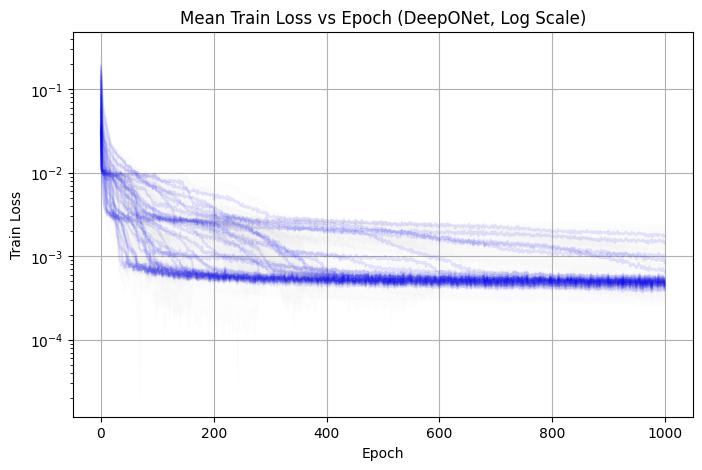

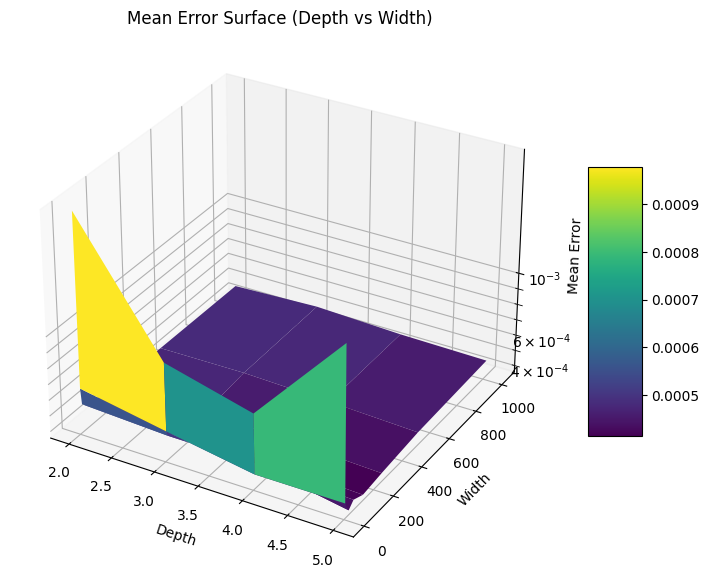

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
widths = don_widths
depths = don_depths
seeds = [0, 1, 2, 3, 4]
don_loss = {}
don_mean_loss = {}
don_std_loss = {}
don_up_loss = {}
don_low_loss = {}
results = {}
for depth in depths:
    don_loss[depth] = {}
    don_mean_loss[depth] = {}
    don_std_loss[depth] = {}
    don_up_loss[depth] = {}
    don_low_loss[depth] = {}
    results[depth] = {}
    for width in widths:
        don_loss[depth][width] = {}
        don_mean_loss[depth][width] = {}
        don_std_loss[depth][width] = {}
        don_up_loss[depth][width] = {}
        don_low_loss[depth][width] = {}
        results[depth][width] = {}
        for seed in seeds:
            results[depth][width][seed] = None
            output_path = f"melt_deeponet_dim4/melt_DeepONet_({depth}, {width}, {depth}, {width})_{seed}.log"
            if not os.path.exists(output_path):
                # print(f"File not found: {output_path}")
                continue
            min_train_loss = float('inf')
            test_loss_at_min_train = None

            with open(output_path, "r") as f:
                for line in f:
                    if line.startswith("Epoch"):
                        parts = line.strip().split(":")
                        if len(parts) == 2:
                            losses = parts[1].split(",")
                            if len(losses) == 2:
                                train_loss = float(losses[0].strip())
                                test_loss = float(losses[1].strip())
                                if train_loss < min_train_loss:
                                    min_train_loss = train_loss
                                    test_loss_at_min_train = test_loss
            results[depth][width][seed] = test_loss_at_min_train
            # results[depth][width][seed] = min_train_loss
for depth in depths:
    row = f"${depth}$"
    for width in widths:
        mse = []
        for seed in seeds:
            if results[depth][width][seed] is not None:
                mse.append(results[depth][width][seed])
        if mse:
            mse_mean = np.mean(mse)
            mse_std = np.std(mse)
        else:
            mse_mean = None
            mse_std = None
        if mse_mean is not None and mse_std is not None:
            row += f" &$ {mse_mean:.6f}\\pm {mse_std:.6f}$"
            # row += f" & {mse_mean:.6f}"
        else:
            row += " & -"
    row += r" \\"
    print(row)
plt.figure(figsize=(8,5))
results = {}
for depth in depths:
    for width in widths:
        output_paths = [
            f"melt_deeponet_dim4/melt_DeepONet_({depth}, {width}, {depth}, {width})_{seed}.log"
            for seed in seeds
        ]

        all_epochs = []
        all_train_loss = []
        all_test_loss = []
        for output_path in output_paths:
            if not os.path.exists(output_path):
                continue
            epochs = []
            train_loss = []
            test_loss = []
            with open(output_path, "r") as f:
                for line in f:
                    if line.startswith("Epoch"):
                        parts = line.strip().split(":")
                        if len(parts) == 2:
                            losses = parts[1].split(",")
                            if len(losses) == 2:
                                epoch_num = int(line.split()[1].split(":")[0])
                                epochs.append(epoch_num)
                                train_loss.append(float(losses[0].strip()))
                                test_loss.append(float(losses[1].strip()))
            all_epochs.append(epochs)
            all_train_loss.append(train_loss)
            all_test_loss.append(test_loss)
        # 对齐所有种子的 epoch（假设每个文件的 epoch 一致）
        epochs = all_epochs[0] if all_epochs else []
        train_loss_array = np.array([loss for loss in all_train_loss if len(loss) == len(epochs)])
        test_loss_array = np.array([loss for loss in all_test_loss if len(loss) == len(epochs)])
        results[(depth, width)] = (np.mean(train_loss_array, axis=0), np.std(train_loss_array, axis=0)) if train_loss_array.shape[0] > 0 else (None, None)
        if train_loss_array.shape[0] > 0:
            mean_loss = np.mean(train_loss_array, axis=0)
            index = []
            for i in range(len(train_loss_array)):
                index.append(np.argmin(train_loss_array[i]) )
            don_loss[depth][width] = [test_loss_array[i][index[i]] for i in range(len(index))]
            don_mean_loss[depth][width] = np.mean(don_loss[depth][width])
            # don_mean_loss[depth][width] = np.mean(train_loss_array, axis=0)[-5]
            std_loss = np.std(train_loss_array, axis=0)
            don_std_loss[depth][width] = np.std(don_loss[depth][width])
            don_up_loss[depth][width] = np.max(don_loss[depth][width])
            don_low_loss[depth][width] = np.min(don_loss[depth][width])

            plt.plot(epochs, mean_loss, color='blue', alpha=0.1, label="Mean Train Loss")
            plt.fill_between(epochs, mean_loss-std_loss, mean_loss+std_loss, color='gray', alpha=0.01, label="Std Range")
        # else:
        #     print("没有足够的数据用于绘图。")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.yscale("log")
plt.title("Mean Train Loss vs Epoch (DeepONet, Log Scale)")
plt.grid(True)
# plt.legend()
plt.show()

Z_don = np.zeros((len(depths), len(widths)))
for i, depth in enumerate(depths):
    for j, width in enumerate(widths):
        if (depth, width) in results:
            mean_loss, std_loss = results[(depth, width)]
            if mean_loss is not None:
                Z_don[i, j] = mean_loss[-1]  # 使用最后一个 epoch 的均值作为热力图值
            else:
                Z_don[i, j] = np.nan  # 如果没有数据，设置为 NaN
X_don, Y_don = np.meshgrid(depths, widths, indexing='ij')  # 保证shape一致

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_don, Y_don, Z_don, cmap='viridis', edgecolor='none')
ax.set_xlabel('Depth')
ax.set_ylabel('Width')
ax.set_zlabel('Mean Error')
ax.set_zscale('log')
ax.set_title('Mean Error Surface (Depth vs Width)')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。
没有足够的数据用于绘图。


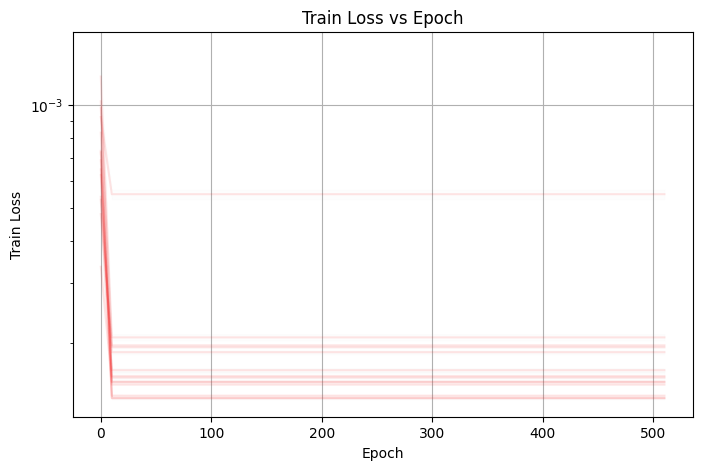

0.00013799959568132182 0.0017435604124329985


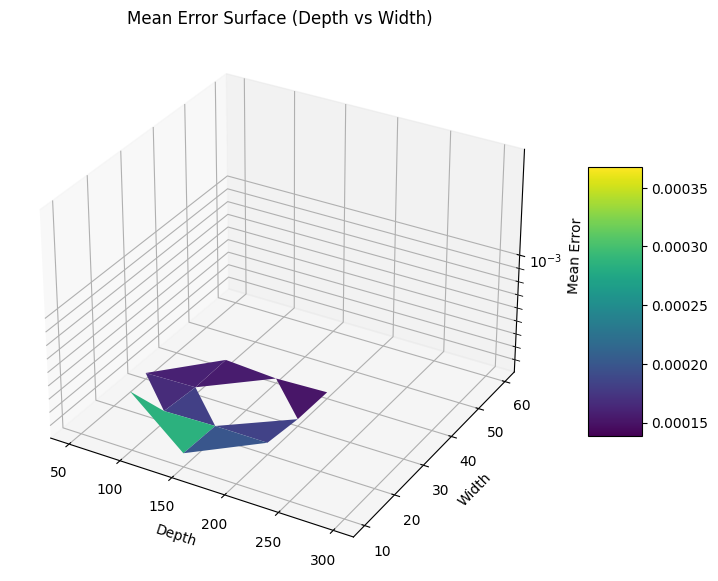

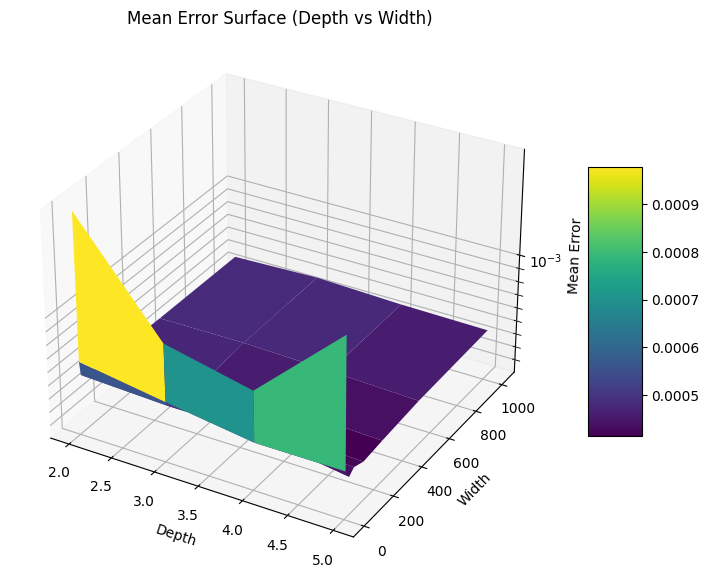

In [44]:
import json
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
# 读取 json 文件
a_list = branch_depths
b_list = trunk_depths
seed_list = [0, 1, 2, 3, 4]
# seed_list = [4]
results = {}
qon_mean_loss = {}
qon_std_loss = {}
qon_up_loss = {}
qon_low_loss = {}
for  a in a_list:
    qon_mean_loss[a] = {}
    qon_std_loss[a] = {}
    qon_up_loss[a] = {}
    qon_low_loss[a] = {}
    for b in b_list:
        output_paths = [
            f"melt_quanonet_dim4_expdamp/logs/Inverse/training_Inverse_TF-QuanONet_2_[{a}, 2, {b}, 2]_seed{seed}_.json"
            for seed in seed_list
        ]

        all_epochs = []
        all_train_loss = []
        all_test_loss = []
        for output_path in output_paths:
            if not os.path.exists(output_path):
                continue
            with open(output_path, "r") as f:
                data = json.load(f)
            train_loss = [item["train_loss"] for item in data["training_history"]]
            test_loss = data['MSE']
            all_epochs.append(epochs)
            all_train_loss.append(train_loss)
            all_test_loss.append(test_loss)
        # epochs = range(0, 1000, 10) 
        train_loss_array = np.array([loss for loss in all_train_loss])

        if train_loss_array.shape[0] > 0:
            mean_loss = np.mean(train_loss_array, axis=0)
            # qon_mean_loss[a][b] = np.mean(all_test_loss)
            qon_mean_loss[a][b] = np.mean(all_train_loss)
            std_loss = np.std(train_loss_array, axis=0)
            # qon_std_loss[a][b] = np.std(all_test_loss)
            qon_std_loss[a][b] = np.std(all_train_loss)
            qon_up_loss[a][b] = np.max(all_test_loss)
            qon_low_loss[a][b] = np.min(all_test_loss)
            results[(a, b)] = (mean_loss, std_loss)
            epochs = [i * 10 for i in range(len(mean_loss))]
            plt.plot(epochs, mean_loss, color='red', alpha=0.1, label="Mean Train Loss")
            plt.fill_between(epochs, mean_loss-std_loss, mean_loss+std_loss, color='gray', alpha=0.01, label="Std Range")
        else:
            print("没有足够的数据用于绘图。")
            qon_mean_loss[a][b] = None
            qon_std_loss[a][b] = None
            qon_up_loss[a][b] = None
            qon_low_loss[a][b] = None
            results[(a, b)] = (None, None)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.yscale("log")  # 设置纵轴为对数
plt.title("Train Loss vs Epoch")
plt.grid(True)
# plt.legend()
plt.show()

Z = np.zeros((len(b_list), len(a_list)))
for i, b in enumerate(b_list):
    for j, a in enumerate(a_list):
        if (a, b) in results:
            mean_loss, std_loss = results[(a, b)]
            if mean_loss is not None:
                Z[i, j] = mean_loss[-1]  # 使用最后一个 epoch 的均值作为热力图值
            else:
                Z[i, j] = np.nan  # 如果没有数据，设置为 NaN
        else:
            Z[i, j] = np.nan  # 如果没有数据，设置为 NaN
X, Y = np.meshgrid(a_list, b_list)

# 计算两个曲面所有的z值的最大最小值
z_min = min(np.nanmin(Z), np.nanmin(Z_don))
if np.isnan(z_min):
    z_min = 1e-6  # 设置一个合理的最小值，避免log(0)的问题
z_max = max(np.nanmax(Z), np.nanmax(Z_don))
if np.isnan(z_max):
    z_max = 1e6  # 设置一个合理的最大值，避免log(Inf)的问题
print(z_min, z_max)
# 第一个图
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_zscale('log')
ax.set_zlim(z_min, z_max)  # 设置z轴范围
ax.set_xlabel('Depth')
ax.set_ylabel('Width')
ax.set_zlabel('Mean Error')
ax.set_title('Mean Error Surface (Depth vs Width)')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# 第二个图
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf_don = ax.plot_surface(X_don, Y_don, Z_don, cmap='viridis', edgecolor='none')
ax.set_zscale('log')
ax.set_zlim(z_min, z_max)  # 设置z轴范围
ax.set_xlabel('Depth')
ax.set_ylabel('Width')
ax.set_zlabel('Mean Error')
ax.set_title('Mean Error Surface (Depth vs Width)')
fig.colorbar(surf_don, shrink=0.5, aspect=5)
plt.show()

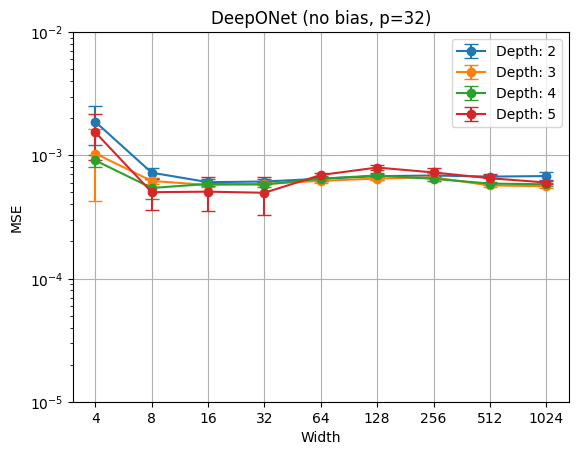

In [45]:
import numpy as np
import matplotlib.pyplot as plt

widths = don_widths
depths = don_depths

for depth in depths:
    mse_means = []
    mse_stds = []
    for width in widths:
        mse = don_mean_loss[depth][width]
        std = don_std_loss[depth][width]
        # 只保留数值类型
        if isinstance(mse, (int, float, np.floating)):
            mse_means.append(mse)
        else:
            mse_means.append(np.nan)
        if isinstance(std, (int, float, np.floating)):
            mse_stds.append(std)
        else:
            mse_stds.append(0)
    plt.errorbar(widths, mse_means, yerr=mse_stds, marker='o', capsize=5, label=f'Depth: {depth}')

plt.xscale('log')
plt.yscale('log')
yrange = (1e-5, 1e-2)
plt.ylim(yrange)
plt.xlabel('Width')
plt.xticks(widths, [str(w) for w in widths])
plt.tick_params(axis='x', which='minor', bottom=False)
plt.ylabel('MSE')
plt.title('DeepONet (no bias, p=32)')
plt.legend()
plt.grid(True)
plt.show()

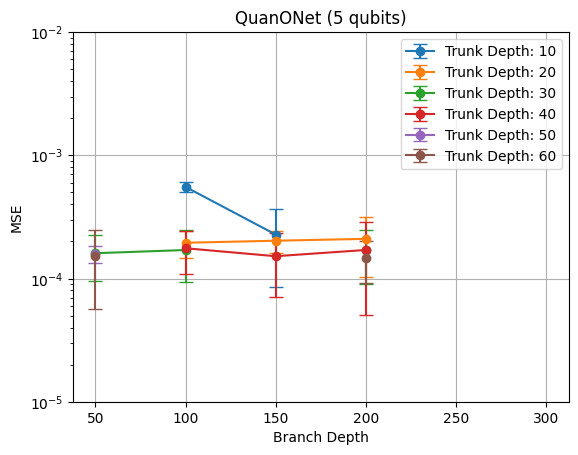

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# 收集每个宽度下不同深度的均值和标准差
for trunk_depth in trunk_depths:
    mse_means = []
    mse_stds = []
    for branch_depth in branch_depths:
        mse_list = []
        # 你的 don_mean_loss[depth][width] 应该是均值列表
        # 这里假设最后一个 epoch 的均值和标准差
        if qon_mean_loss[branch_depth][trunk_depth] is not None:
            mse = qon_mean_loss[branch_depth][trunk_depth]
            mse_means.append(mse)
            if qon_std_loss[branch_depth][trunk_depth] is not None:
                mse_stds.append(qon_std_loss[branch_depth][trunk_depth])
            else:
                mse_stds.append(0)
            
        else:
            mse_means.append(np.nan)
            mse_stds.append(0)
    plt.errorbar(branch_depths, mse_means, yerr=mse_stds, marker='o', capsize=5, label=f'Trunk Depth: {trunk_depth}')

# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Branch Depth')
plt.ylim(yrange)  # 根据你的数据范围调整
plt.xticks(branch_depths, [str(w) for w in branch_depths])  # 让所有宽度均匀显示
plt.tick_params(axis='x', which='minor', bottom=False)  # 隐藏x轴小刻度线
plt.ylabel('MSE')
plt.title('QuanONet (5 qubits)')
plt.legend()
plt.grid(True)
plt.show()

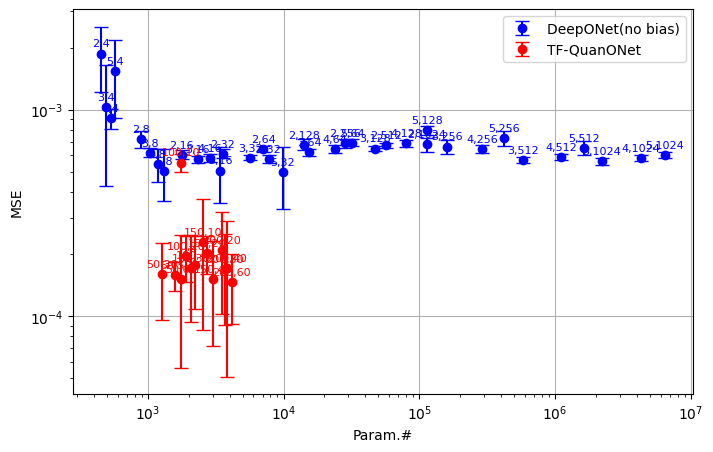

In [47]:
import matplotlib.pyplot as plt
import os

# DeepONet
widths = don_widths
depths = don_depths
param_counts_deep = []
mse_means_deep = []
mse_stds_deep = []
mse_up_deep = []
mse_low_deep = []
labels_deep = []

for depth in depths:
    for width in widths:
        log_file = f"melt_deeponet_dim4/melt_DeepONet_({depth}, {width}, {depth}, {width})_0.log"
        if os.path.exists(log_file):
            with open(log_file, "r") as f:
                first_line = f.readline()
                if "params num:" in first_line:
                    param_num = int(first_line.split("params num:")[1].split(",")[0].strip())
                    param_counts_deep.append(param_num)
                    mse = don_mean_loss[depth][width] if don_mean_loss[depth][width] is not None else np.nan
                    std = don_std_loss[depth][width] if don_std_loss[depth][width] is not None else 0
                    up = don_up_loss[depth][width] if don_up_loss[depth][width] is not None else np.nan
                    low = don_low_loss[depth][width] if don_low_loss[depth][width] is not None else np.nan
                    mse_up_deep.append(up)
                    mse_low_deep.append(low)
                    mse_means_deep.append(mse)
                    mse_stds_deep.append(std)
                    labels_deep.append(f"{depth},{width}")

# QuanONet
param_counts_quan = []
mse_means_quan = []
mse_stds_quan = []
mse_up_quan = []
mse_low_quan = []
labels_quan = []

for branch_depth in branch_depths:
    for trunk_depth in trunk_depths:
        param_num = (branch_depth + trunk_depth) * 16
        param_counts_quan.append(param_num)
        mse = qon_mean_loss[branch_depth][trunk_depth] if qon_mean_loss[branch_depth][trunk_depth] is not None else np.nan
        std = qon_std_loss[branch_depth][trunk_depth] if qon_std_loss[branch_depth][trunk_depth] is not None else 0
        up = qon_up_loss[branch_depth][trunk_depth] if qon_up_loss[branch_depth][trunk_depth] is not None else np.nan
        low = qon_low_loss[branch_depth][trunk_depth] if qon_low_loss[branch_depth][trunk_depth] is not None else np.nan
        
        mse_means_quan.append(mse)
        mse_stds_quan.append(std)
        mse_up_quan.append(up)
        mse_low_quan.append(low)
        labels_quan.append(f"{branch_depth},{trunk_depth}")

plt.figure(figsize=(8,5))
plt.errorbar(param_counts_deep, mse_means_deep, yerr=mse_stds_deep, fmt='o', capsize=5, linestyle='None', color='blue', label='DeepONet(no bias)')
# plt.plot(param_counts_deep, mse_means_deep, 'o-', color='blue', label='DeepONet(no bias)')
# plt.plot(param_counts_deep, mse_low_deep, '--', color='blue', alpha=0.5)
# plt.plot(param_counts_deep, mse_up_deep, '--', color='blue', alpha=0.5)
for x, y, label in zip(param_counts_deep, mse_means_deep, labels_deep):
    plt.annotate(label, (x, y), color='blue', textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

plt.errorbar(param_counts_quan, mse_means_quan, yerr=mse_stds_quan, fmt='o', capsize=5, linestyle='None', color='red', label='TF-QuanONet')
# plt.plot(param_counts_quan, mse_means_quan, 'o-', color='red', label='TF-QuanONet')
# plt.plot(param_counts_quan, mse_low_quan, '--', color='red', alpha=0.5)
# plt.plot(param_counts_quan, mse_up_quan, '--', color='red', alpha=0.5)
for x, y, label in zip(param_counts_quan, mse_means_quan, labels_quan):
    plt.annotate(label, (x, y), color='red', textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Param.#')
plt.ylabel('MSE')
# plt.title('Antiderivative Operator')
plt.legend()
plt.grid(True)

In [ ]:
import numpy as np
operators = ['Inverse', 'Homogeneous', 'Nonlinear', 'RDiffusion', 'Advection', 'Darcy']
DE_dict = {
    'Inverse': "ODE",
    'Homogeneous': "ODE",
    'Nonlinear': "ODE",
    'RDiffusion': "PDE",
    'Advection': "PDE",
    'Darcy': "PDE"
}
for operator in operators:
    num_points = 1000 if DE_dict[operator] == "ODE" else 100
    if operator == "Darcy":
        num_points = 25
    file_path = f"data/{operator}_Operator_data/{operator}_Operator_data_{num_points}_1.npz"
    data = np.load(file_path)

    for key in data.files:
        arr = data[key]
        if np.issubdtype(arr.dtype, np.number):
            print(f"{key}: min={arr.min()}, max={arr.max()}")

u_cals: min=-2.071175832459728, max=2.243199461274201
u0_cals: min=-4.331122387393699, max=3.999453496387554
u_cals: min=-3.680717535268255, max=4.402917068903037
u0_cals: min=-4.205365414227341, max=4.056995287696639
u_cals: min=-26.573721948301813, max=1.4491409709389518
u0_cals: min=-4.094241836512901, max=3.7887909085327403


FileNotFoundError: [Errno 2] No such file or directory: 'data/RDiffusion_Operator_data/RDiffusion_Operator_data_10000_1.npz'